# target encoder & ohe & just auoint

In [2]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, auto_int, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [4]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [5]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [6]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:10, 54663.57it/s]


In [7]:
ecd.fit(test_df, verbose=1)

400000it [00:07, 50823.96it/s]


In [8]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:13, 44255.09it/s]
400000it [00:09, 44250.33it/s]


# Search Max LR

In [9]:
%%time
%matplotlib inline

batch_size = 8192
epochs = 5
nflold = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy', 
               'use_linear': False, 'use_deep': False}

mf = MaxLrFinder(1e-5, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf]}

model = auto_int(**model_param)

cv = CV(model, nflold)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 479999 samples, validate on 120001 samples
Epoch 1/5
479999/479999 [==============================] - 9s 18us/sample - loss: 0.6930 - AUC: 0.5000 - val_loss: 0.6926 - val_AUC: 0.5000
Epoch 2/5
479999/479999 [==============================] - 4s 8us/sample - loss: 0.6912 - AUC: 0.5005 - val_loss: 0.6865 - val_AUC: 0.5000
Epoch 3/5
479999/479999 [==============================] - 4s 8us/sample - loss: 0.5483 - AUC: 0.5213 - val_loss: 0.4564 - val_AUC: 0.7565
Epoch 4/5
479999/479999 [==============================] - 4s 8us/sample - loss: 0.4159 - AUC: 0.7647 - val_loss: 0.4018 - val_AUC: 0.7804
Epoch 5/5
479999/479999 [==============================] - 4s 8us/sample - loss: 0.4626 - AUC: 0.7046 - val_loss: 0.5403 - val_AUC: 0.5000
folds 0 is done, score is 0.4993831285765756
Train on 479999 samples, validate on 120001 samples
Epoch 1/5
479999/479999 [==============================] - 6s 13us/sample - loss: 0.6926 - AUC: 0.5000 - val_loss: 0.6917 - val_AUC: 0.5000
Epoch 2/5
47999

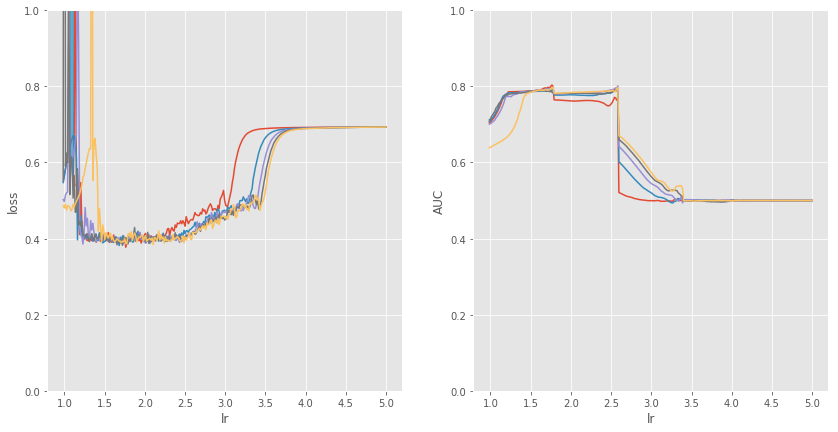

In [10]:
%matplotlib inline
mf.plot(True, [0, 1])

# fit one

In [11]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_linear': False,
               'use_deep': False,
               'attem_size': 32,
               'head_num': 2,
               'use_res': True,
               'num_att_layer': 4}

clr = CyclicLR(base_lr=0.1**(4),
               max_lr = 0.1**(3), 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = auto_int(**model_param)

CPU times: user 387 ms, sys: 16.4 ms, total: 404 ms
Wall time: 392 ms


In [12]:
cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train,
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 479999 samples, validate on 120001 samples
Epoch 1/100
479999/479999 [==============================] - 9s 20us/sample - loss: 0.6341 - AUC: 0.5025 - val_loss: 0.4860 - val_AUC: 0.5564
Epoch 2/100
479999/479999 [==============================] - 7s 14us/sample - loss: 0.4604 - AUC: 0.6664 - val_loss: 0.4226 - val_AUC: 0.7654
Epoch 3/100
479999/479999 [==============================] - 7s 14us/sample - loss: 0.4010 - AUC: 0.7840 - val_loss: 0.3979 - val_AUC: 0.7855
Epoch 4/100
479999/479999 [==============================] - 7s 14us/sample - loss: 0.3922 - AUC: 0.7940 - val_loss: 0.3993 - val_AUC: 0.7850
Epoch 5/100
479999/479999 [==============================] - 7s 14us/sample - loss: 0.3909 - AUC: 0.7955 - val_loss: 0.3984 - val_AUC: 0.7854
Epoch 6/100
479999/479999 [==============================] - 7s 14us/sample - loss: 0.3888 - AUC: 0.7983 - val_loss: 0.3982 - val_AUC: 0.7854
folds 0 is done, score is 0.7855214453874152
Train on 479999 samples, validate on 120001 samples

# Tuning

In [16]:
batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=0.1**(4),
               max_lr = 0.1**(3),
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False, 
                   'use_deep': False}

ss = {
    'loss': (hp.choice, ('binary_crossentropy', 'focal_loss')), 
    'k': (hp.choice, (5, 7, 8, 10)),
    'attem_size': (hp.choice, (8, 16, 24, 32)),
    'head_num': (hp.choice, (2, 4, 8)),
    'num_att_layer': (hp.choice, (1, 2, 3 ,4)),
    'use_res': (hp.choice, (True, False)),
    'l2_em': (hp.loguniform, (-20, 0))}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=auto_int, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7875, param {'attem_size': 16, 'head_num': 4, 'k': 7, 'l2_em': 1.9636880193907704e-06, 'loss': 'focal_loss', 'num_att_layer': 4, 'use_res': False}
new best, eval 2, score -0.7875, param {'attem_size': 32, 'head_num': 8, 'k': 8, 'l2_em': 0.00011468858251758283, 'loss': 'focal_loss', 'num_att_layer': 2, 'use_res': False}
new best, eval 4, score -0.7885, param {'attem_size': 24, 'head_num': 8, 'k': 8, 'l2_em': 0.0009794306094931505, 'loss': 'binary_crossentropy', 'num_att_layer': 1, 'use_res': True}
new best, eval 83, score -0.7885, param {'attem_size': 8, 'head_num': 4, 'k': 8, 'l2_em': 0.00011860208873323203, 'loss': 'binary_crossentropy', 'num_att_layer': 1, 'use_res': True}
100%|██████████| 100/100 [9:33:49<00:00, 296.32s/trial, best loss: -0.7884974569026613] 


{'attem_size': 0,
 'head_num': 1,
 'k': 2,
 'l2_em': 0.00011860208873323203,
 'loss': 0,
 'num_att_layer': 0,
 'use_res': 0}

In [17]:
log = tuning.log.get_log()

In [28]:
log.sort_values('score').head(20)

,score,update,usetime,attem_size,head_num,k,l2_em,loss,num_att_layer,use_res
82,-0.788497,True,182.209614,8,4,8,0.000119,binary_crossentropy,1,True
3,-0.788480,True,407.163541,24,8,8,0.000979,binary_crossentropy,1,True
37,-0.788443,False,283.700739,8,8,5,0.000210,binary_crossentropy,1,True
67,-0.788359,False,179.864107,24,2,8,0.000322,binary_crossentropy,1,True
20,-0.788325,False,174.139315,24,2,8,0.000278,binary_crossentropy,1,True
92,-0.788292,False,595.053502,8,8,5,0.002652,binary_crossentropy,1,True
97,-0.788263,False,382.264821,8,8,10,0.000062,focal_loss,1,True
77,-0.788236,False,240.438969,24,4,8,0.000325,binary_crossentropy,1,True
45,-0.788220,False,426.223242,32,4,5,0.000058,focal_loss,1,False
85,-0.788218,False,352.668170,8,4,5,0.000099,binary_crossentropy,3,False


In [29]:
log.sort_values('score').tail(20)

,score,update,usetime,attem_size,head_num,k,l2_em,loss,num_att_layer,use_res
87,-0.786197,False,394.063744,8,4,8,0.020357,binary_crossentropy,4,True
64,-0.786046,False,355.965616,24,8,8,0.006920,binary_crossentropy,1,False
91,-0.784298,False,456.634569,32,4,8,0.040301,binary_crossentropy,3,True
73,-0.783674,False,300.189005,24,2,8,0.010999,binary_crossentropy,1,True
81,-0.783368,False,980.019882,24,8,5,0.085398,binary_crossentropy,4,False
46,-0.783233,False,467.967804,16,8,10,0.119930,binary_crossentropy,2,True
33,-0.782901,False,372.052575,8,4,8,0.012218,binary_crossentropy,1,True
47,-0.782478,False,722.494802,8,8,7,0.708521,binary_crossentropy,4,True
11,-0.781821,False,442.090829,16,4,10,0.026854,focal_loss,4,False
8,-0.781813,False,474.103853,16,8,5,0.326305,binary_crossentropy,2,True


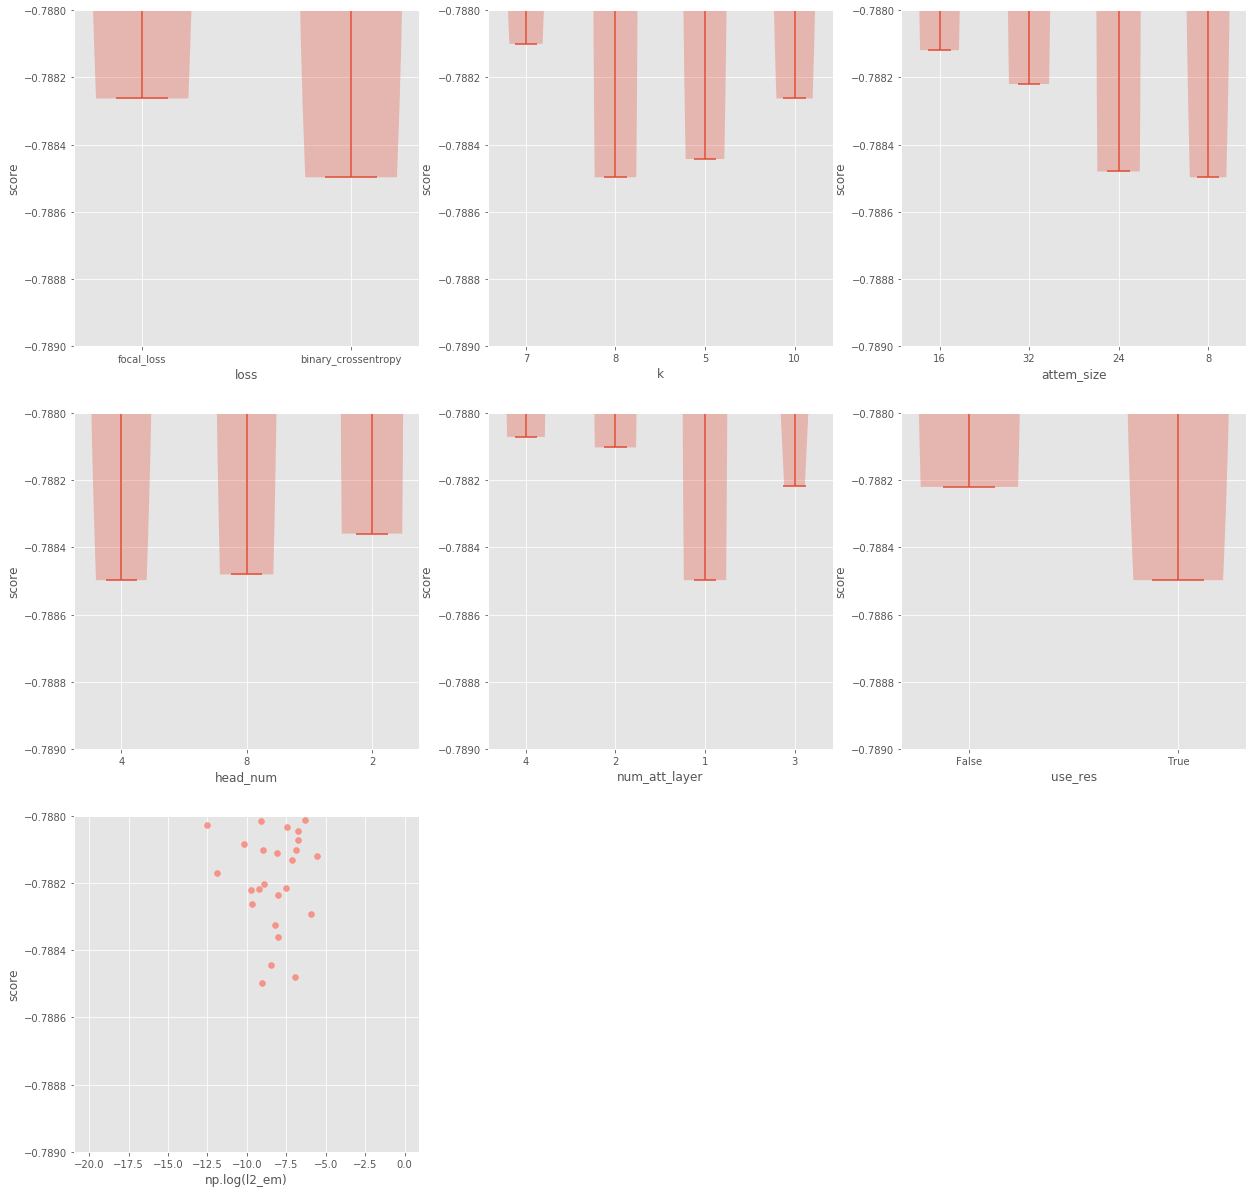

In [32]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.789, -0.788])

# Tuning 2

In [34]:
batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=0.1**(4),
               max_lr = 0.1**(3),
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False, 
                   'use_deep': False,
                   'loss': 'binary_crossentropy',
                   'use_res':True}

ss = {
    'k': (hp.choice, (5, 8)),
    'attem_size': (hp.choice, (8, 16, 24, 32)),
    'head_num': (hp.choice, (2, 4, 8)),
    'num_att_layer': (hp.choice, (1, 2, 3 ,4)),
    'l2_em': (hp.loguniform, (-12.5, -5)),
    'att_act': (hp.choice, ('mish', 'gelu')),
    'att_dropout': (hp.uniform, (0, 0.5)),
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=auto_int, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7879, param {'att_act': 'gelu', 'att_dropout': 0.3250927276177025, 'attem_size': 24, 'head_num': 4, 'k': 5, 'l2_em': 7.489472424130253e-05, 'num_att_layer': 1}
new best, eval 2, score -0.788, param {'att_act': 'mish', 'att_dropout': 0.4368452642003841, 'attem_size': 24, 'head_num': 4, 'k': 5, 'l2_em': 0.0004989336049412917, 'num_att_layer': 4}
new best, eval 4, score -0.788, param {'att_act': 'gelu', 'att_dropout': 0.25206241028768295, 'attem_size': 8, 'head_num': 4, 'k': 5, 'l2_em': 0.00015745222215499688, 'num_att_layer': 3}
new best, eval 10, score -0.788, param {'att_act': 'mish', 'att_dropout': 0.431698732925426, 'attem_size': 32, 'head_num': 2, 'k': 5, 'l2_em': 0.00027885112180993886, 'num_att_layer': 3}
new best, eval 11, score -0.7881, param {'att_act': 'gelu', 'att_dropout': 0.03690357889220347, 'attem_size': 24, 'head_num': 2, 'k': 5, 'l2_em': 0.0006993920033416361, 'num_att_layer': 4}
new best, eval 15, score -0.7882, param {'att_act': 'mish', 'att

{'att_act': 1,
 'att_dropout': 0.29154545289063155,
 'attem_size': 2,
 'head_num': 2,
 'k': 1,
 'l2_em': 0.0005229226155746144,
 'num_att_layer': 0}

In [35]:
log = tuning.log.get_log()

In [36]:
log.sort_values('score').head(20)

,score,update,usetime,att_act,att_dropout,attem_size,head_num,k,l2_em,num_att_layer
67,-0.788614,True,357.177192,gelu,0.291545,24,8,8,0.000523,1
37,-0.788593,True,358.537135,gelu,0.462664,24,8,8,0.000583,1
35,-0.788562,True,371.834383,gelu,0.338013,24,8,8,0.000535,1
59,-0.788549,False,348.101777,gelu,0.274191,24,8,8,0.000394,1
32,-0.788544,True,369.119631,gelu,0.361885,24,8,8,0.000525,1
94,-0.788535,False,386.533759,gelu,0.336044,24,8,8,0.000868,1
68,-0.788523,False,374.898220,gelu,0.296920,24,8,8,0.000499,1
48,-0.788519,False,375.247446,gelu,0.398376,32,8,8,0.000755,1
26,-0.788508,True,726.991519,gelu,0.159320,16,8,8,0.002960,3
30,-0.788505,False,385.886990,gelu,0.357452,24,8,8,0.000460,1


In [37]:
log.sort_values('score').tail(20)

,score,update,usetime,att_act,att_dropout,attem_size,head_num,k,l2_em,num_att_layer
38,-0.787560,False,230.855332,gelu,0.463211,24,8,8,0.000037,1
51,-0.787493,False,90.503766,mish,0.477171,24,2,8,0.000009,1
82,-0.787491,False,242.185168,gelu,0.304242,8,2,5,0.000607,3
7,-0.787386,False,170.880876,gelu,0.403663,16,8,8,0.000013,1
49,-0.787384,False,156.015916,mish,0.224786,8,4,5,0.000026,2
52,-0.787316,False,470.402958,gelu,0.375822,32,8,5,0.000079,2
19,-0.787313,False,158.673993,mish,0.386699,16,4,8,0.000019,2
12,-0.787290,False,140.100327,gelu,0.279834,8,4,8,0.000017,2
50,-0.787289,False,932.884767,gelu,0.440066,24,8,8,0.000109,4
89,-0.787252,False,429.163511,gelu,0.404009,8,8,8,0.000029,3


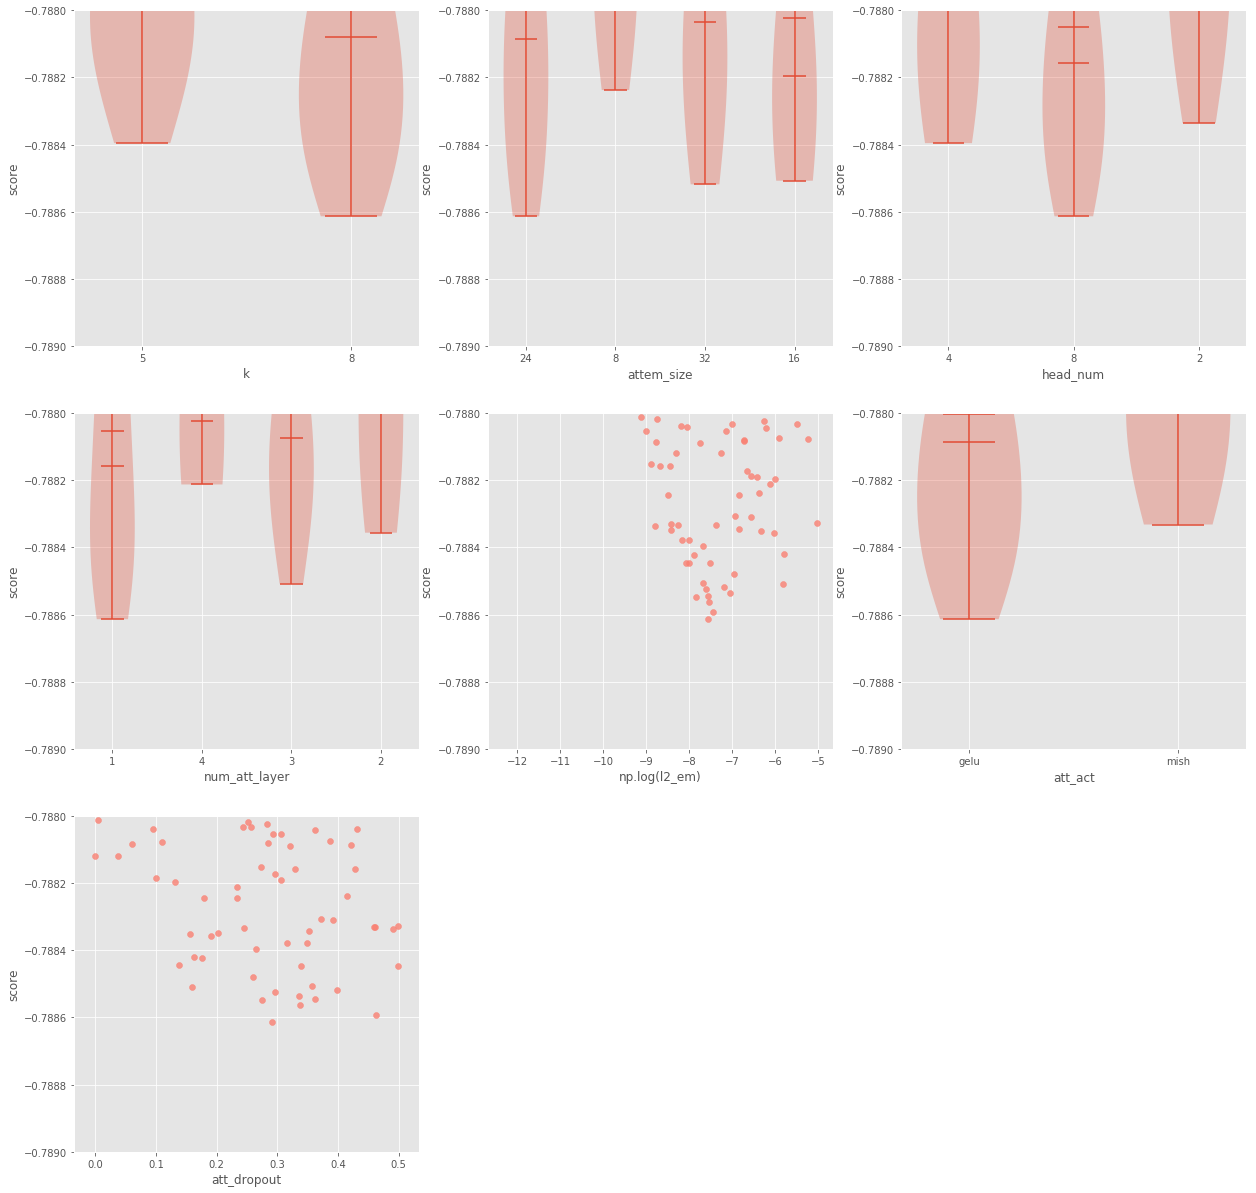

In [38]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.789, -0.788])

In [39]:
seed = np.random.randint(2**32)

### 2072349059

In [19]:
! mkdir ../tmp/autoint

In [40]:
log.to_csv(f'../tmp/autoint/{seed}.csv', index=False)

In [41]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 5

In [45]:
# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False, 
                   'use_deep': False,
                   'loss': 'binary_crossentropy',
                   'use_res':True}

In [43]:
# callbacks
clr = CyclicLR(
    base_lr=1e-4,
    max_lr = 0.1**(3), 
    step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

# Stacking 1

In [ ]:
pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = {}
    for param_name, param_value in model_fix_param.items():
        model_params[param_name] = param_value
        
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = auto_int(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=[idx, val],
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=[idx_test, val_test], pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    tf.keras.backend.clear_session()

folds 0 is done, score is 0.786460260490979
folds 1 is done, score is 0.7864839557702137
folds 2 is done, score is 0.7844855078913018
folds 3 is done, score is 0.793202866201554
folds 4 is done, score is 0.7868331529338748
folds 5 is done, score is 0.789807115122896
folds 6 is done, score is 0.7814729142597827
folds 7 is done, score is 0.7966342093689944
folds 8 is done, score is 0.7835202407257853
folds 9 is done, score is 0.7849988970395796
folds 10 is done, score is 0.7916629132129049
folds 11 is done, score is 0.7849401562184535
folds 12 is done, score is 0.7850964576276256
folds 13 is done, score is 0.7928422717526228
folds 14 is done, score is 0.795407253530408
folds 15 is done, score is 0.79355512126489
folds 16 is done, score is 0.7961944856886212
folds 17 is done, score is 0.7901120357751756
folds 18 is done, score is 0.7864632551773708
folds 19 is done, score is 0.787916791100231
folds 20 is done, score is 0.7856472514086114
folds 21 is done, score is 0.787021395212217
folds 

folds 18 is done, score is 0.7864257060348759
folds 19 is done, score is 0.7880255974446836
folds 20 is done, score is 0.7851732354736374
folds 21 is done, score is 0.7871294274981118
folds 22 is done, score is 0.7836352687484577


In [ ]:
pred_arr = np.array(pred_arr_lst).squeeze().T
np.save(f'../tmp/autoint/{seed}stacking1.npy', pred_arr)
pred_arr.shape

In [ ]:
pred = np.array(pred_lst).squeeze().T
np.save(f'../tmp/autoint/{seed}predict.npy', pred)
pred.shape

In [ ]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = np.mean(pred_lst, axis=0)
submission.to_csv(f'/data/main_7_autoint_{seed}.csv')